## Predicciones de Etiqueta de Delito Seguimiento

En este notebook se realiza la prediccion de la etiqueta según el modelo entrenado para un dataset que contenga la cantidad de ndds operadas por la comisión.

* Coder: LeninGF
* Fecha: 2022-12-20

Primero se verifica que las Ndds a predecir no consten en el dataset de entrenamiento $Ndd_i \notin  \mathbf{\mathcal{X}}_{TRAIN}$ y $Ndd_i \in \mathbf{\mathcal{X}}_{TEST}  $

In [1]:
import pandas as pd
import os
file_path=os.path.join(os.getcwd(), 'data/processed/validacionJunio2022.csv')
xtest = pd.read_csv(file_path, converters={'NDD':str})
xtest.shape

(5571, 7)

In [2]:
xtest.head()

,NDD,Tipo_Delito_PJ,delitos_seguimiento,delitos_validados,desagregacion,desagregacion_1,RELATO
0,010101822050033,ROBO,ROBO A PERSONAS,ROBO A PERSONAS,ROBO A PERSONAS,SIN INFORMACION,señora fiscal ayer 02 de mayo de 2022 entre la...
1,010101822050042,ROBO,ROBO A PERSONAS,ROBO A PERSONAS,ROBO A PERSONAS,SIN INFORMACION,es el caso señor fiscal que el día 02 de mayo ...
2,010101822050083,ROBO,ROBO A PERSONAS,ROBO A PERSONAS,ROBO A PERSONAS,SIN INFORMACION,es el caso señor fiscal que el dia de ayer mar...
3,010101822050128,ROBO,ROBO A PERSONAS,ROBO A PERSONAS,ROBO A PERSONAS,SIN INFORMACION,es el caso señor fiscal que el dia domingo 1 d...
4,010101822050132,ROBO,ROBO A UNIDADES ECONOMICAS,ROBO A UNIDADES ECONOMICAS,ROBO A DOMICILIO,SIN INFORMACION,señora fiscal el día 01 de mayo de 2022 a eso ...


$\mathbf{\mathcal{X}}_{TEST} \cap\mathbf{\mathcal{X}}_{TRAIN} = 0 $

In [3]:
file_path=os.path.join(os.getcwd(), 'data/raw/dataset.csv')
xtrain = pd.read_csv(file_path, converters={'NDD':str})
xtrain.shape

(431669, 12)

In [4]:
set(xtest.NDD.to_list()).intersection(xtrain.NDD.to_list())

set()

## Carga del Modelo

Se procede a realizar la carga del Modelo para realizar la predicción de las etiquetas según el relato de la Ndd

In [5]:
from transformers import pipeline
from transformers import AutoTokenizer

PATH_MODEL = '/home/falconiel/ML_Models/robbery_tf20221113'
model_ckpt = "distilbert-base-multilingual-cased"
SEQ_LEN = 300
tokenizer = AutoTokenizer.from_pretrained(model_ckpt,  padding="max_length", truncation=True, max_length=SEQ_LEN)
classifier = pipeline("text-classification", model=PATH_MODEL, tokenizer=tokenizer)

2022-12-21 10:59:39.995128: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-21 10:59:45.533493: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-21 10:59:45.534824: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
All model checkpoint layers were used when initializing TFDistilBertForSequen

In [6]:
def predictLabelAndScore(x):
    y_hat_dict = classifier(x, truncation=True)[0]
    label = y_hat_dict['label']
    score = y_hat_dict['score']
    return label, score

In [7]:
xtest["cantidad_palabras"] = xtest.RELATO.apply(lambda x: len(x.split(' ')))

<AxesSubplot: >

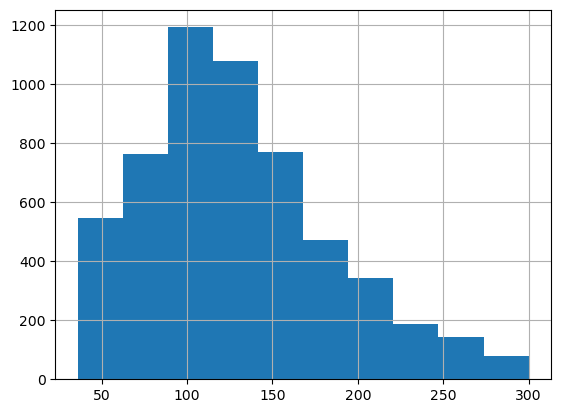

In [8]:
xtest.cantidad_palabras.hist()

In [9]:
xtest2 = xtest[4940:4950]

In [12]:
from tqdm import tqdm
y_hat_series = []
score_series = []
for relato in tqdm(xtest.RELATO.to_list()):
    y_hat_dict = classifier(relato, truncation=True)[0]
    label = y_hat_dict['label']
    score = y_hat_dict['score']
    y_hat_series.append(label)
    score_series.append(score)
    # print(f"{len(relato.split(' '))}, {label}, {score}")

predicted_labels = pd.Series(y_hat_series)
score_series = pd.Series(score_series)

100%|██████████| 5571/5571 [23:09<00:00,  4.01it/s]


In [13]:
len(predicted_labels), len(score_series)

(5571, 5571)

In [14]:
%%time
xtest[['delitos_seguimiento_predicted','score']] = xtest.apply(lambda x: predictLabelAndScore(x['RELATO']), axis=1, result_type='expand')


CPU times: user 1h 31min 8s, sys: 3min 42s, total: 1h 34min 50s
Wall time: 22min 16s


In [16]:
xtest[['NDD', 'delitos_seguimiento', 'cantidad_palabras', 'delitos_seguimiento_predicted', 'score']].sample(5)

,NDD,delitos_seguimiento,cantidad_palabras,delitos_seguimiento_predicted,score
4453,170101822052922,ROBO A PERSONAS,156,ROBO A PERSONAS,0.999708
3781,130901822050021,ROBO A PERSONAS,144,ROBO A PERSONAS,0.999799
2893,091101822050105,SIN INFORMACION,225,"ROBO DE BIENES, ACCESORIOS Y AUTOPARTES DE VEH...",0.883794
4034,170101822051072,ROBO A DOMICILIO,57,ROBO A DOMICILIO,0.951764
1319,090101822051490,ROBO A DOMICILIO,269,ROBO A DOMICILIO,0.998879


In [21]:
# xtest[xtest.delitos_seguimiento=="SIN INFORMACION"].sample(5)
xtest.RELATO.iloc[5334]

'adjunta denuncia escrita el señor luis alfredo morocho masaco procurador judicial de la empresa pública ep petroecuador en el que hace conocer un presunto delito de robo de bienes publicos suscitado en el sector aguarico precooperativa la primavera'

## Evaluación del Modelo

Con las predicciones realizadas en la variable delitos_seguimiento_predicted y con el valor correspondiende de probabilidad $P(y_i|X_i)$, se procede a realizar la evaluación de desempeño sobre este nuevo dataset de prueba

Debe observarse las siguientes posibles threats to validity (amanezas a la validación):

1. El $ \mathbf{ \mathcal{X}}_test $ se generó descartando relatos superiores a 300 palabras. Se debe realizar la prueba con los valores superiores a 300 observando el truncamiento del vector de codificación y de máscara de acuerdo al modelo. 

2. No se ha retirado la etiqueta **SIN INFORMACION**, por lo que el modelo carece de esta variable y por tanto realizara una predicción en función de las etiquetas que tiene disponible y dado el score de probabilidad

3. El caso anterior permite hacer correcciones sobre la etiqueta predicha, ya que sí se puede considerar error humano, mientras que se espera que un modelo de aprendizaje automático converga hacia una predicción más acertada en función de la cantidad de datos suministrados. Los casos de **SIN INFORMACION** deben ser revisados

4. En el entrenamiento del modelo se utilizó como límite inferior la cantidad de palabras superior a 35. No obstante, como se muestra en el índice 5334, el mensaje indica que la denuncia escrita se adjunta y no se digitaliza. Es evidente que una mejora sería procesar el documento digitalizado. Aun cuando esto pueda significar el verdadero desarrollo de una arquitectura diferente a la BERT para procesar documentos más extensos.

5. También debe observarse que existen varios ejemplos en donde el relato está mal escrito (i.e. errores ortográficos y de forma). Se sugiere que exista las correcciones de la escritura de estos documentos, puyes se supone que se cuenta con personal profesional, y además la digitación equivocada puede llevar a intentar confundir al aprendizaje automático

## Reporte de Clasificación

In [22]:
from sklearn.metrics import classification_report
print(classification_report(y_true=xtest.delitos_seguimiento.to_list(),
                            y_pred=xtest.delitos_seguimiento_predicted.to_list()))

                                                      precision    recall  f1-score   support

                                    ROBO A DOMICILIO       0.63      0.83      0.72       506
                                     ROBO A PERSONAS       0.89      0.89      0.89      2111
                          ROBO A UNIDADES ECONOMICAS       0.50      0.78      0.61       257
ROBO DE BIENES, ACCESORIOS Y AUTOPARTES DE VEHICULOS       0.68      0.92      0.78       575
                                      ROBO DE CARROS       0.92      0.87      0.89       654
                                       ROBO DE MOTOS       0.95      0.94      0.95       992
                                     SIN INFORMACION       0.00      0.00      0.00       476

                                            accuracy                           0.81      5571
                                           macro avg       0.65      0.75      0.69      5571
                                        weighted avg      

/home/falconiel/anaconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/falconiel/anaconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/falconiel/anaconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

Si eliminamos la categoría de Sin información se obtiene el siguiente resultado

In [23]:
xtest6 = xtest[xtest.delitos_seguimiento!="SIN INFORMACION"]
xtest6.shape, xtest.shape

((5095, 10), (5571, 10))

In [24]:
print(classification_report(y_true=xtest6.delitos_seguimiento.to_list(),
                            y_pred=xtest6.delitos_seguimiento_predicted.to_list()))

                                                      precision    recall  f1-score   support

                                    ROBO A DOMICILIO       0.86      0.83      0.85       506
                                     ROBO A PERSONAS       0.92      0.89      0.91      2111
                          ROBO A UNIDADES ECONOMICAS       0.66      0.78      0.72       257
ROBO DE BIENES, ACCESORIOS Y AUTOPARTES DE VEHICULOS       0.76      0.92      0.84       575
                                      ROBO DE CARROS       0.95      0.87      0.91       654
                                       ROBO DE MOTOS       0.96      0.94      0.95       992

                                            accuracy                           0.89      5095
                                           macro avg       0.85      0.87      0.86      5095
                                        weighted avg       0.90      0.89      0.89      5095



## Matriz de Confusión

In [25]:
class_labels = list(set(xtest.delitos_seguimiento.to_list()))
class_labels

['ROBO DE MOTOS',
 'ROBO A DOMICILIO',
 'SIN INFORMACION',
 'ROBO A PERSONAS',
 'ROBO DE CARROS',
 'ROBO DE BIENES, ACCESORIOS Y AUTOPARTES DE VEHICULOS',
 'ROBO A UNIDADES ECONOMICAS']

<AxesSubplot: >

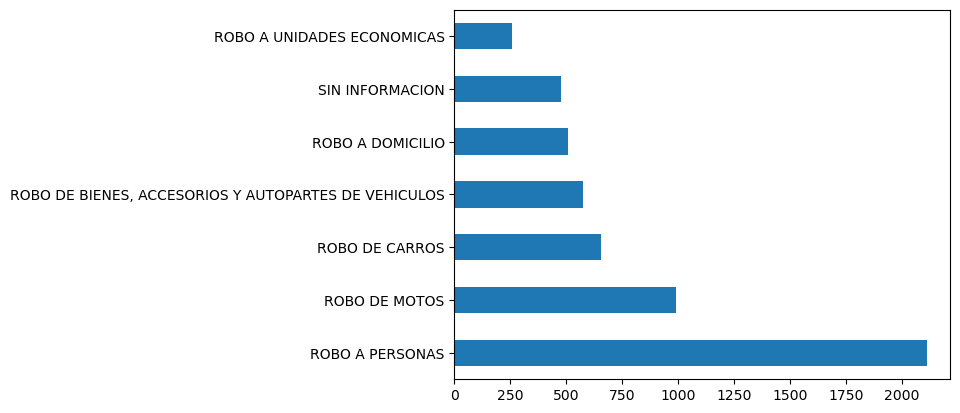

In [28]:
xtest.delitos_seguimiento.value_counts().plot.barh()

In [26]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_true=xtest.delitos_seguimiento.to_list(),
                      y_pred=xtest.delitos_seguimiento_predicted.to_list(), 
                      labels=class_labels)
print(cm)

[[ 931    5    0   37    6    9    4]
 [   9  422    0   26    0   29   20]
 [   7  181    0   81   24   85   98]
 [  22   40    0 1887   21   68   73]
 [   4    3    0   35  568   40    4]
 [   0    4    0   37    1  530    3]
 [   3   14    0   22    0   17  201]]


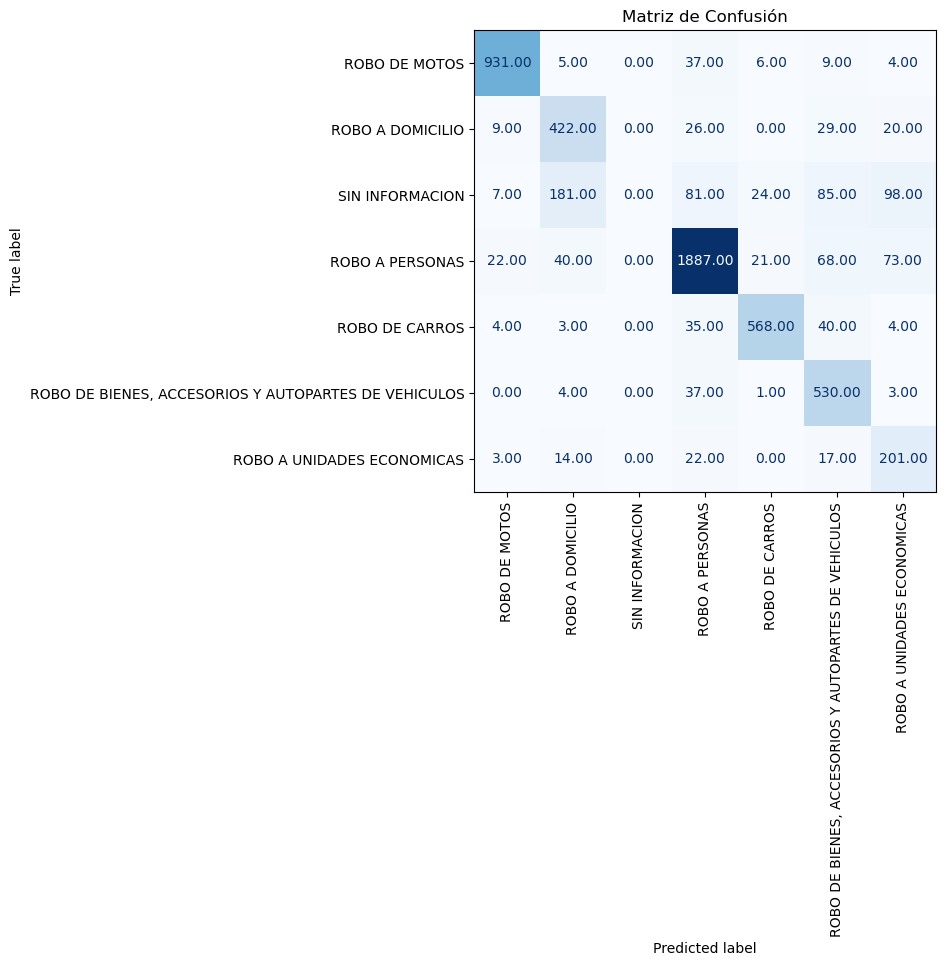

In [27]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(6,6))
disp = ConfusionMatrixDisplay(cm, display_labels=class_labels)
disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
plt.title("Matriz de Confusión")
font = {'family' : 'normal',
    'weight' : 'normal',
    'size'   : 32}
# plt.rc('font', **font)
# ax.label_size = 32
disp.ax_.set_xticklabels(class_labels, rotation=90)
plt.show()

In [36]:
sin_informacion = xtest[(xtest.delitos_seguimiento=="SIN INFORMACION")]
sin_informacion[['NDD', 'delitos_seguimiento', 'RELATO', 'delitos_seguimiento_predicted', 'score']].sort_values(by='score', ascending=True).head()

,NDD,delitos_seguimiento,RELATO,delitos_seguimiento_predicted,score
5351,220101822050014,SIN INFORMACION,mediante parte policial nro 202205030500549301...,ROBO A PERSONAS,0.258872
5570,240301822060007,SIN INFORMACION,señorita agente fiscal pongo a conocimiento el...,"ROBO DE BIENES, ACCESORIOS Y AUTOPARTES DE VEH...",0.361459
2917,091401822050055,SIN INFORMACION,ha llegado a mi conocimiento el oficio nro pn ...,"ROBO DE BIENES, ACCESORIOS Y AUTOPARTES DE VEH...",0.398998
1646,090101822052682,SIN INFORMACION,es el caso señor fiscal que el día de hoy lune...,ROBO A DOMICILIO,0.412624
832,080101822050307,SIN INFORMACION,adjunto a la presente el oficio no pn dinased ...,"ROBO DE BIENES, ACCESORIOS Y AUTOPARTES DE VEH...",0.422767


In [37]:
sin_informacion.describe()

,cantidad_palabras,score
count,476.000000,476.000000
mean,112.231092,0.884891
std,55.453813,0.157058
min,36.000000,0.258872
25%,70.000000,0.812470
50%,102.500000,0.968658
75%,138.250000,0.996940
max,281.000000,0.999886


## Matriz de Confusión Normalizada

In [29]:
cmn = confusion_matrix(y_true=xtest.delitos_seguimiento.to_list(),
                      y_pred=xtest.delitos_seguimiento_predicted.to_list(), 
                      labels=class_labels,
                      normalize='true')
print(cmn)

[[0.93850806 0.00504032 0.         0.03729839 0.00604839 0.00907258
  0.00403226]
 [0.01778656 0.83399209 0.         0.0513834  0.         0.05731225
  0.03952569]
 [0.01470588 0.3802521  0.         0.17016807 0.05042017 0.17857143
  0.20588235]
 [0.0104216  0.01894837 0.         0.89388915 0.00994789 0.03221222
  0.03458077]
 [0.00611621 0.00458716 0.         0.05351682 0.86850153 0.06116208
  0.00611621]
 [0.         0.00695652 0.         0.06434783 0.00173913 0.92173913
  0.00521739]
 [0.01167315 0.05447471 0.         0.08560311 0.         0.06614786
  0.78210117]]


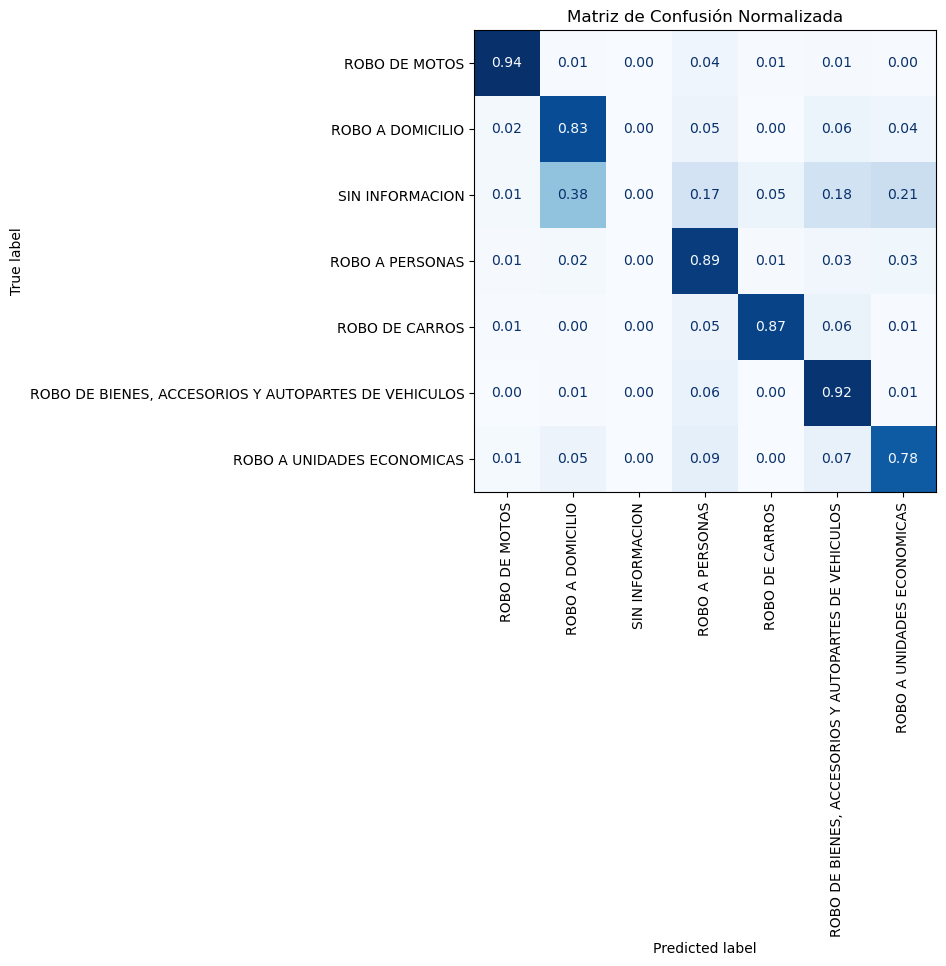

In [30]:
fig, ax = plt.subplots(figsize=(6,6))
disp = ConfusionMatrixDisplay(cmn, display_labels=class_labels)
disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
plt.title("Matriz de Confusión Normalizada")
font = {'family' : 'normal',
    'weight' : 'normal',
    'size'   : 32}
# plt.rc('font', **font)
# ax.label_size = 32
disp.ax_.set_xticklabels(class_labels, rotation=90)
plt.show()

## Matriz de Confusión excluyendo SIN INFORMACION

In [31]:
class_labels.pop(2)

'SIN INFORMACION'

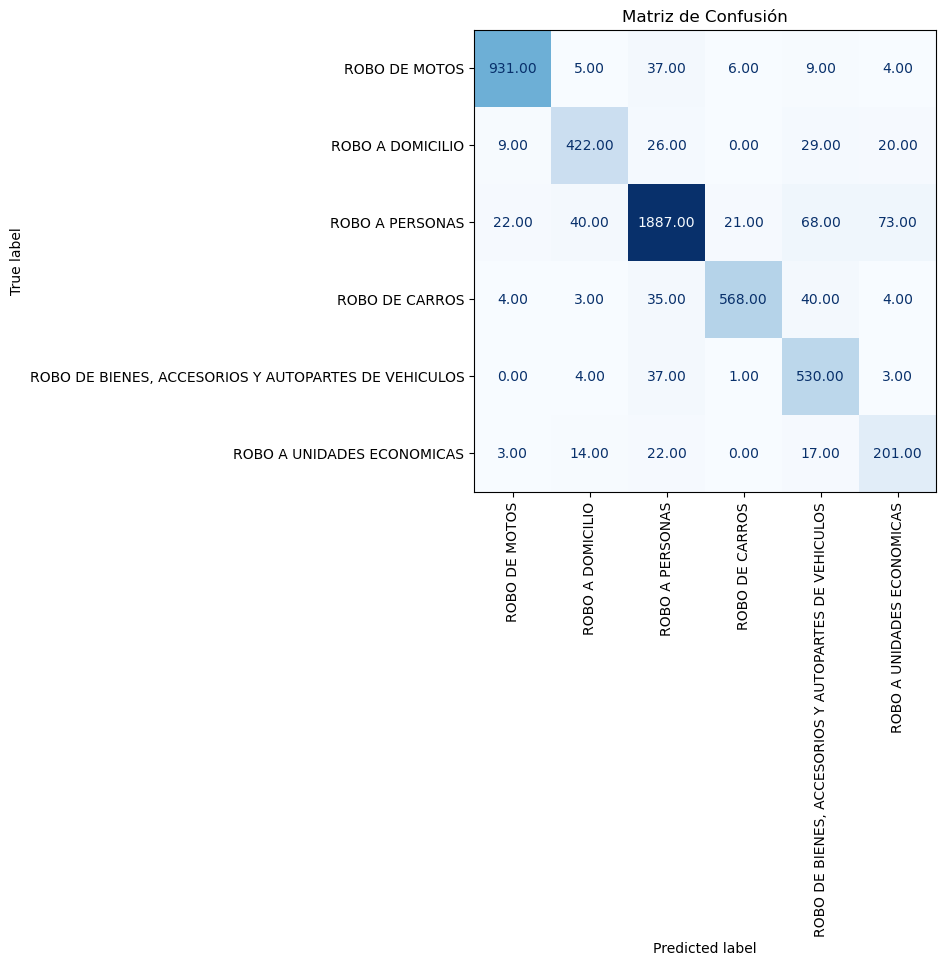

In [32]:
cm = confusion_matrix(y_true=xtest6.delitos_seguimiento.to_list(),
                      y_pred=xtest6.delitos_seguimiento_predicted.to_list(), 
                      labels=class_labels)
fig, ax = plt.subplots(figsize=(6,6))
disp = ConfusionMatrixDisplay(cm, display_labels=class_labels)
disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
plt.title("Matriz de Confusión")
font = {'family' : 'normal',
    'weight' : 'normal',
    'size'   : 32}
# plt.rc('font', **font)
# ax.label_size = 32
disp.ax_.set_xticklabels(class_labels, rotation=90)
plt.show()

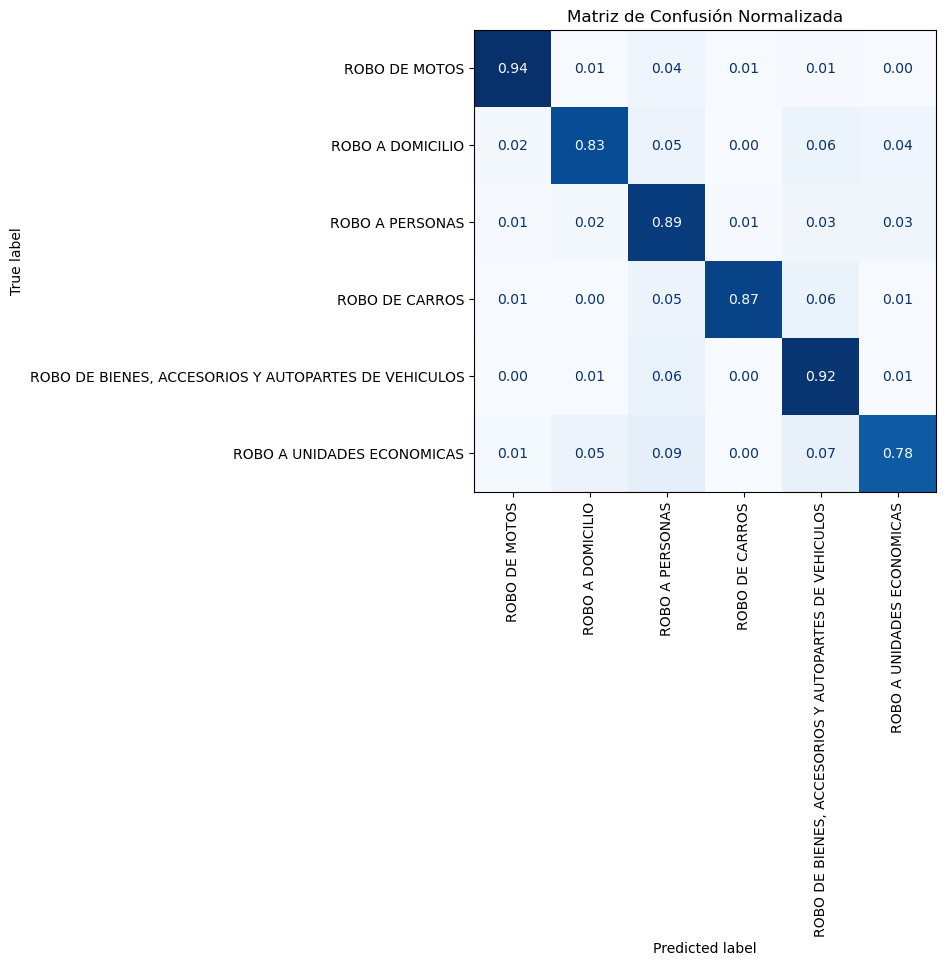

In [33]:
cm = confusion_matrix(y_true=xtest6.delitos_seguimiento.to_list(),
                      y_pred=xtest6.delitos_seguimiento_predicted.to_list(), 
                      labels=class_labels,
                      normalize='true')
fig, ax = plt.subplots(figsize=(6,6))
disp = ConfusionMatrixDisplay(cm, display_labels=class_labels)
disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
plt.title("Matriz de Confusión Normalizada")
font = {'family' : 'normal',
    'weight' : 'normal',
    'size'   : 32}
# plt.rc('font', **font)
# ax.label_size = 32
disp.ax_.set_xticklabels(class_labels, rotation=90)
plt.show()